In this experiment I try treating the data like an image and apply 2D convolution. The idea is that a 1D kernel applies the weights to every growth phase and the kernel may be too general and underfit. Treating the data as a 1043 x 3 image (1043 readings by 3 growth phases) and using a 2D kernel may enable the model to learn kernels that are more specific to each growth phase.

# Model
The model used in this experiment is a CNN consisting of two 2-D convolutional layers, followed by a global average pooling layer and a softmax layer. The convolutional layers have 32 and 64 filters each. 
A 3 x 3 kernel with same padding is used to ensure that the three growth phase data series are not 'squashed' into the same row by the convolution layers.

A global average pooling layer is used instead of flattening and it significantly reduces the dimensionality of the input going into the softmax layer. This way fully connected layers are not always necessary and the number of parameters in the model are kept to a minimum. 

# Data
The model is trained on data from all growth phases using an integration time of 16ms. 
The data is put into the NWHC format where the width is the fluorence spectra for a given bacteria sample at a given growth phase, H is the number of growth phases (three), and C is just one. The model is classifying the species of a given bacteria sample.

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, GlobalAvgPool2D

In [2]:
os.getcwd()

'/home/anthony/bacteria-project/individual_experiments'

In [3]:
os.listdir('../data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'bacteria_32ms.csv',
 'PC6allwavelengths.png',
 'bacteria_16ms.csv',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df_16ms = pd.read_csv('../data/bacteria_16ms.csv', header=[0, 1, 2, 3], index_col=0)
df_16ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, positive, bc, 01) to (stat, negative, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


In [5]:
df_16ms.describe()

growth_phase          lag                                                      \
gramness         positive                                                       
species                bc                                                       
replicate              01           02           03           04           05   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           340.917966   218.282554   410.265450   402.411758   147.930946   
std            517.453981   328.263253   632.792734   584.358827   213.381498   
min             -3.510400    -2.800760    -2.581292    -2.554170    -2.985820   
25%              3.738191     2.116139     3.614560     4.258268     3.017208   
50%             40.780240    27.023980    48.616896    58.972290    24.396270   
75%            496.754350   319.173550   571.801010   629.260350   223.730650   
max           1649.755000  1044.867000  2050.509445  1755.384000   670.982500   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              06           07           08           09           10   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           304.443366   690.243351   615.625463   508.217097   267.395909   
std            457.365956  1076.320701  1006.404767   829.675942   411.266389   
min             -3.429370    -2.280780    -4.327390    -3.340390   -24.324100   
25%              3.429760     4.382186     3.291279     3.093110    -1.435505   
50%             37.316280    78.138510    46.407810    41.594080    26.498390   
75%            446.739200   940.880800   775.154550   630.964700   401.714900   
max           1426.308000  3542.053000  3369.752000  2848.575000  1316.226000   

growth_phase     ...              stat                                         \
gramness         ...          positive                               negative   
species          ...                sa                                     se   
replicate        ...                06           07           08           01   
count            ...       1043.000000  1043.000000  1043.000000  1043.000000   
mean             ...       1319.282527  1617.105057  1424.455291   332.375709   
std              ...       2183.988762  2683.151537  2381.357464   525.271213   
min              ...        -18.529200    -2.563420    -1.462970    -2.361310   
25%              ...         11.080080    12.687795    10.883005     2.919165   
50%              ...        107.911900   130.242300   104.561900    33.991250   
75%              ...       1577.928000  1936.329500  1679.898000   436.948300   
max              ...       7512.713000  9235.687000  8223.580000  1713.175000   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              02           03           04           05           06   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           464.757981   346.619581   591.019431   944.666722   683.460369   
std            783.676339   589.041597  1030.124114  1631.945511  1174.686894   
min             -3.337340    -2.003951    -2.814100    -3.369360    -3.098660   
25%              3.433975     2.271594     7.036556     5.055340     3.809488   
50%             34.734540    22.254616    41.866360    52.880860    42.561820   
75%            533.983350   395.229638   603.002400  1030.629000   753.640300   
max           2670.119000  2010.552740  3632.655000  5669.533000  4091.082000   

growth_phase               
gramness                   
species                    
replicate              0

In [6]:
growth_phase_dfs = []

for growth_phase in ['lag', 'log', 'stat']:
    growth_phase_df = df_16ms[growth_phase].T
    growth_phase_df = growth_phase_df.add_prefix('%s_' % growth_phase)
    print(growth_phase_df.shape)
    growth_phase_dfs.append(growth_phase_df)
    
growth_phase_df = pd.concat(growth_phase_dfs, axis=1).dropna(axis=0)

channels = (growth_phase_df.filter(regex='lag').values, 
            growth_phase_df.filter(regex='log').values, 
            growth_phase_df.filter(regex='stat').values)

print(channels[0].shape, channels[1].shape, channels[2].shape)

channels = np.array(list(map(lambda c: np.expand_dims(c, axis=2), channels)))
print(channels.shape)

(47, 1043)
(41, 1043)
(47, 1043)
(39, 1043) (39, 1043) (39, 1043)
(3, 39, 1043, 1)


In [7]:
X = np.concatenate(channels, axis=2)
print(X.shape)

X = np.expand_dims(X, axis=3)
print(X.shape)

# Scaling to [0.0, 1.0] improves convergence. 
# Relative scale between features are retained when done this way, rather than using sklearn's MinMaxScaler.
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max())
print(X[:5])

(39, 1043, 3)
(39, 1043, 3, 1)
0.0 1.0
[[[[0.00194437]
   [0.00193525]
   [0.00197465]]

  [[0.00200981]
   [0.00192787]
   [0.00189666]]

  [[0.0020677 ]
   [0.00199924]
   [0.00197953]]

  ...

  [[0.00199723]
   [0.00201401]
   [0.00204046]]

  [[0.00199723]
   [0.00193525]
   [0.00198197]]

  [[0.00192927]
   [0.00201893]
   [0.00196003]]]


 [[[0.00200738]
   [0.00194004]
   [0.00198455]]

  [[0.00193418]
   [0.00198203]
   [0.00189506]]

  [[0.00200486]
   [0.00200673]
   [0.00197461]]

  ...

  [[0.00192913]
   [0.00199932]
   [0.00204669]]

  [[0.00196447]
   [0.00194745]
   [0.00195969]]

  [[0.00196699]
   [0.00194745]
   [0.00197461]]]


 [[[0.0019721 ]
   [0.00199878]
   [0.00190086]]

  [[0.00200207]
   [0.00194185]
   [0.00196862]]

  [[0.00194961]
   [0.00200149]
   [0.0020025 ]]

  ...

  [[0.0019671 ]
   [0.00193371]
   [0.00197427]]

  [[0.00195461]
   [0.00193642]
   [0.00199968]]

  [[0.00199208]
   [0.00203674]
   [0.00204203]]]


 [[[0.00195235]
   [0.00197709]
  

In [8]:
from sklearn.preprocessing import OneHotEncoder

y = growth_phase_df.reset_index()['species']
y = y.values
y = y.reshape(-1, 1)

print(y.shape)
print(y[:5])

(39, 1)
[['ec']
 ['ec']
 ['ec']
 ['ec']
 ['ec']]


In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

X[:5]

array([[[[0.00196262],
         [0.00199691],
         [0.00193339]],

        [[0.0019602 ],
         [0.00191764],
         [0.00191396]],

        [[0.00198433],
         [0.00193251],
         [0.00201594]],

        ...,

        [[0.00194814],
         [0.00203654],
         [0.00197709]],

        [[0.00192884],
         [0.00201672],
         [0.00199652]],

        [[0.00207118],
         [0.00197957],
         [0.00204993]]],


       [[[0.00201303],
         [0.00201737],
         [0.00204477]],

        [[0.00194115],
         [0.00198968],
         [0.00189733]],

        [[0.00192318],
         [0.0021961 ],
         [0.00189732]],

        ...,

        [[0.00203774],
         [0.00170264],
         [0.0021681 ]],

        [[0.00196137],
         [0.00185121],
         [0.00191907]],

        [[0.00192992],
         [0.00193678],
         [0.00174485]]],


       [[[0.00195408],
         [0.00200672],
         [0.00194879]],

        [[0.001984  ],
         [0.0019845 ],

In [10]:
y[:5]

array([['sa'],
       ['sa'],
       ['ec'],
       ['se'],
       ['lm']], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(31, 1043, 3, 1) (8, 1043, 3, 1)
(31, 1) (8, 1)


In [12]:
N, W, H, C = X.shape
print(N, W, H, C)

39 1043 3 1


In [13]:
k = len(np.unique(y))
print(k)

6


In [57]:
def get_model():
    tf.keras.backend.clear_session()
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(W, H, C)))
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='elu'))

    model.add(GlobalAvgPool2D())
    model.add(Dense(k, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [58]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1043, 3, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1043, 3, 32)       9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 9,766
Trainable params: 9,766
Non-trainable params: 0
_________________________________________________________________


In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,)

ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.fit_transform(y_test)

history = model.fit(X_train, y_train_encoded,
          epochs=1000,
          validation_data=(X_test, y_test_encoded),
         callbacks=[early_stopping])

score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss: %.2f' % score[0])
print('Test accuracy: %.2f' % score[1])

Train on 31 samples, validate on 8 samples
Epoch 1/1000
31/31 [==============================] - 1s 24ms/step - loss: 1.7949 - acc: 0.1290 - val_loss: 1.7817 - val_acc: 0.2500
Epoch 2/1000
31/31 [==============================] - 0s 13ms/step - loss: 1.7786 - acc: 0.3226 - val_loss: 1.7715 - val_acc: 0.2500
Epoch 3/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.7660 - acc: 0.3226 - val_loss: 1.7617 - val_acc: 0.2500
Epoch 4/1000
31/31 [==============================] - 0s 12ms/step - loss: 1.7534 - acc: 0.3226 - val_loss: 1.7516 - val_acc: 0.2500
Epoch 5/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.7404 - acc: 0.3226 - val_loss: 1.7417 - val_acc: 0.2500
Epoch 6/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.7270 - acc: 0.3226 - val_loss: 1.7320 - val_acc: 0.2500
Epoch 7/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.7137 - acc: 0.3226 - val_loss: 1.7229 - val_acc: 0.2500
Epoch 8/1000
31/31 [=======

31/31 [==============================] - 0s 9ms/step - loss: 1.3303 - acc: 0.4516 - val_loss: 1.3676 - val_acc: 0.3750
Epoch 63/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.3250 - acc: 0.4516 - val_loss: 1.3629 - val_acc: 0.3750
Epoch 64/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.3198 - acc: 0.4516 - val_loss: 1.3545 - val_acc: 0.3750
Epoch 65/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.3156 - acc: 0.4516 - val_loss: 1.3583 - val_acc: 0.3750
Epoch 66/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.3124 - acc: 0.4516 - val_loss: 1.3423 - val_acc: 0.3750
Epoch 67/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.3078 - acc: 0.4516 - val_loss: 1.3442 - val_acc: 0.3750
Epoch 68/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.3019 - acc: 0.4516 - val_loss: 1.3342 - val_acc: 0.3750
Epoch 69/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.2

31/31 [==============================] - 0s 11ms/step - loss: 1.1723 - acc: 0.4516 - val_loss: 1.2191 - val_acc: 0.3750
Epoch 124/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.1707 - acc: 0.4839 - val_loss: 1.2070 - val_acc: 0.3750
Epoch 125/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.1692 - acc: 0.4516 - val_loss: 1.2172 - val_acc: 0.3750
Epoch 126/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.1677 - acc: 0.4839 - val_loss: 1.2043 - val_acc: 0.3750
Epoch 127/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.1661 - acc: 0.4516 - val_loss: 1.2150 - val_acc: 0.3750
Epoch 128/1000
31/31 [==============================] - 0s 11ms/step - loss: 1.1645 - acc: 0.4839 - val_loss: 1.2018 - val_acc: 0.3750
Epoch 129/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.1630 - acc: 0.4516 - val_loss: 1.2126 - val_acc: 0.3750
Epoch 130/1000
31/31 [==============================] - 0s 10ms/step -

Epoch 184/1000
31/31 [==============================] - 0s 13ms/step - loss: 1.0636 - acc: 0.5484 - val_loss: 1.1478 - val_acc: 0.6250
Epoch 185/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.0614 - acc: 0.5484 - val_loss: 1.1404 - val_acc: 0.5000
Epoch 186/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.0594 - acc: 0.5484 - val_loss: 1.1459 - val_acc: 0.6250
Epoch 187/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.0573 - acc: 0.5484 - val_loss: 1.1404 - val_acc: 0.5000
Epoch 188/1000
31/31 [==============================] - 0s 10ms/step - loss: 1.0553 - acc: 0.5484 - val_loss: 1.1440 - val_acc: 0.6250
Epoch 189/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.0535 - acc: 0.5806 - val_loss: 1.1413 - val_acc: 0.5000
Epoch 190/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.0517 - acc: 0.5484 - val_loss: 1.1420 - val_acc: 0.6250
Epoch 191/1000
31/31 [==============================] - 0s 

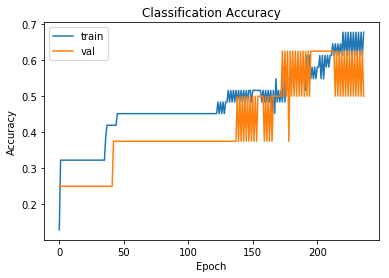

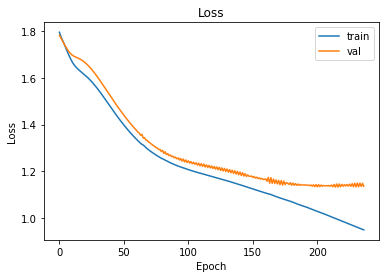

In [60]:
import matplotlib.pyplot as plt


%matplotlib inline

acc_history = history.history['acc']
val_acc_history = history.history['val_acc']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = np.arange(len(acc_history))

plt.plot(epochs, acc_history, label='train')
plt.plot(epochs, val_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss_history, label='train')
plt.plot(epochs, val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [61]:
%%time

from time import time

from sklearn.model_selection import RepeatedStratifiedKFold

n_epochs=200

n_splits = 3
n_repeats = 20
n_total = n_splits * n_repeats
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

score_history = []

i = 0
start = time()

def print_progress(epoch, _):
    msg = 'Iteration %d/%d' % (i + 1, n_total)
    msg += ' - '
    msg += 'Epoch %d/%d' % (epoch, n_epochs)
    msg += ' - '

    total_epochs_done = epoch + i * n_epochs
    total_epochs = n_splits * n_repeats * n_epochs
    msg += 'Progress: %d/%d' % (total_epochs_done, total_epochs)
    msg += ' - '

    elapsed = time() - start
    mins = elapsed // 60
    secs = int(elapsed % 60)
    msg += 'Elapsed time: %02dm %02ds' % (mins, secs)

    n_whitespace = max(0, 80 - len(msg))
    msg += ' ' * n_whitespace

    print(msg, end='\r')

epoch_progress_logger = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=print_progress
)

print('Fitting %d folds over %d repetitions for a total of %d fits.' % (n_splits, n_repeats, n_total))

for train_idx, val_idx in cv.split(X, y):    
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv= y[val_idx]

    # Encoding is not done directly on y so that the k-fold splitter doesn't throw an exception.
    ohe = OneHotEncoder(sparse=False)
    y_train_cv = ohe.fit_transform(y_train_cv)
    y_val_cv = ohe.fit_transform(y_val_cv)
    
    model = get_model() 

    history = model.fit(X_train_cv, y_train_cv,
                        epochs=n_epochs,
                        validation_data=(X_val_cv, y_val_cv),
                        callbacks=[epoch_progress_logger],
                        verbose=0)
    
    score_history.append(history.history)
    
    i += 1

print()

Fitting 3 folds over 20 repetitions for a total of 60 fits.
Iteration 60/60 - Epoch 199/200 - Progress: 11999/12000 - Elapsed time: 49m 35s 
CPU times: user 1h 48min 10s, sys: 14min 45s, total: 2h 2min 55s
Wall time: 49min 35s


In [62]:
acc_history = []
val_acc_history = []
loss_history = []
val_loss_history = []

for i in range(len(score_history)):
    acc_history.append(np.array(score_history[i]['acc']))
    val_acc_history.append(np.array(score_history[i]['val_acc']))
    loss_history.append(np.array(score_history[i]['loss']))
    val_loss_history.append(np.array(score_history[i]['val_loss']))
    
acc_history = np.array(acc_history)
val_acc_history = np.array(val_acc_history)
loss_history = np.array(loss_history)
val_loss_history = np.array(val_loss_history)

print(acc_history.shape, val_acc_history.shape)

(60, 200) (60, 200)


In [63]:
print('Validation Accuracy: %.2f +/- %.2f' % (val_acc_history[:, -1].mean(), 2 *  val_acc_history[:, -1].std()))
print('Max. Validation Accuracy: %.2f' % val_acc_history.max())

Validation Accuracy: 0.54 +/- 0.26
Max. Validation Accuracy: 0.82


In [64]:
def plot_stats(metric, train_data, val_data):
    epochs = np.arange(train_data.shape[1])

    train_mean = train_data.mean(axis=0)
    train_std = 2 * train_data.std(axis=0)
    val_mean = val_data.mean(axis=0)
    val_std = 2 * val_data.std(axis=0)

    plt.figure(figsize=(11, 8))

    plt.plot(train_mean, label='train mean')
    plt.fill_between(epochs, train_mean+train_std, train_mean-train_std, facecolor='blue', alpha=0.25, label='train $\pm 2 \sigma$')

    plt.plot(val_mean, label='val mean')
    plt.fill_between(epochs, val_mean+val_std, val_mean-val_std, facecolor='orange', alpha=0.25, label='val $\pm 2 \sigma$')

    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

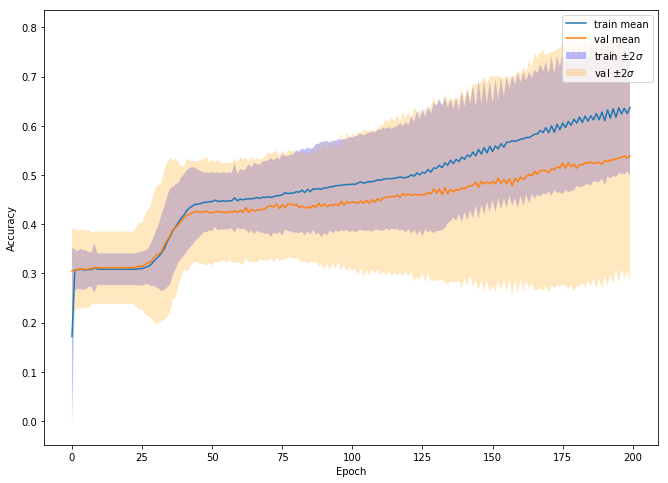

In [65]:
plot_stats('Accuracy', acc_history, val_acc_history)

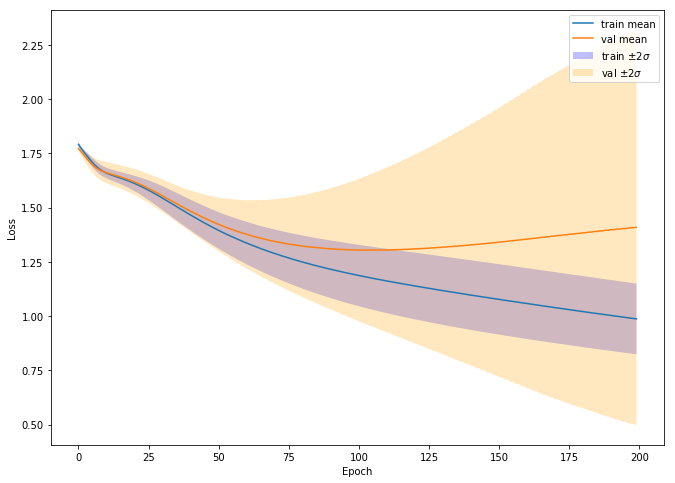

In [66]:
plot_stats('Loss', loss_history, val_loss_history)